<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/rotate_Load_digit_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import imutils

from sklearn.datasets import load_digits
import sklearn

In [128]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [129]:
dataset = load_digits()

In [130]:
X = dataset.data
y = dataset.target

"""std_scale = sklearn.preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)"""

'std_scale = sklearn.preprocessing.StandardScaler().fit(X)\nX = std_scale.transform(X)'

In [131]:
X1 = X[y == 1]

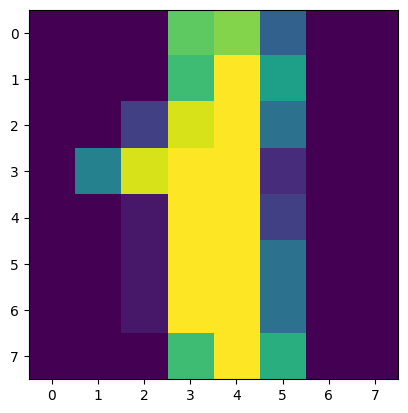

In [132]:
plt.imshow(X1[0].reshape((8,8)))

In [133]:
class Sin(nn.Module):
  def forward(self, x):
    return torch.sin(x)

In [134]:
dim = X1.shape[1]
hidden = 256



model = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model2 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model3 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model4 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model5 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model6 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.ReLU())

model7 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model8 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model9 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model9 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model10 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model11 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model12 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.LeakyReLU())

model13 = nn.Sequential(nn.Conv2d(1, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Conv2d(32, 32, 1), nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(1024, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, hidden), nn.LeakyReLU(),
                      nn.Linear(hidden, 32), nn.ReLU())

In [135]:
"""def coupling_layer(x, m, flow, forward=True):

    x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
    x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

    if forward:
        y_b = x_b - m(x_a)
    else:
        y_b = x_b + m(x_a.reshape(-1,1,4,8))

    z = torch.empty(x.shape)
    z[:, ::2] = x_a if flow%2==0 else y_b
    z[:, 1::2] = y_b if flow%2==0 else x_a
    return z"""

'def coupling_layer(x, m, flow, forward=True):\n\n    x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]\n    x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]\n\n    if forward:\n        y_b = x_b - m(x_a)\n    else:\n        y_b = x_b + m(x_a.reshape(-1,1,4,8))\n\n    z = torch.empty(x.shape)\n    z[:, ::2] = x_a if flow%2==0 else y_b\n    z[:, 1::2] = y_b if flow%2==0 else x_a\n    return z'

In [136]:
def coupling_layer(x, m, flow, forward=True):
    dim = x.shape[1]//2
    x_a = x[:, :dim] if flow%2==0 else x[:, dim:]
    x_b = x[:, dim:] if flow%2==0 else x[:, :dim]

    if forward:
        y_b = x_b - m(x_a)
    else:
        y_b = x_b + m(x_a.reshape(-1,1,4,8))

    z = torch.empty(x.shape)
    z[:, :dim] = x_a if flow%2==0 else y_b
    z[:, dim:] = y_b if flow%2==0 else x_a
    return z

In [137]:
rotated_X1 = np.zeros((X1.shape))
for i in range(len(X1)):
  rot = imutils.rotate(torch.from_numpy(X1[i]).detach().numpy().reshape(8,8), angle=90).reshape((1,64))
  rotated_X1[i] = rot
rotated_X1 = torch.from_numpy(rotated_X1).to(torch.float32)

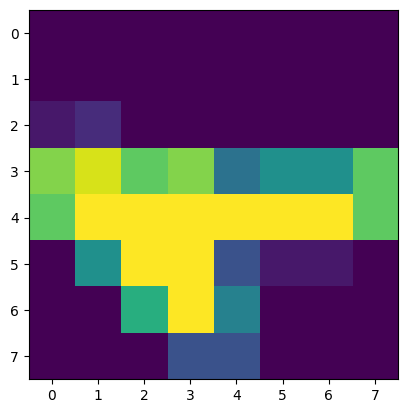

In [138]:
plt.imshow(rotated_X1[5].reshape((8,8)))

In [139]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mse = nn.MSELoss()

n_epochs = 10000
for epoch in range(n_epochs):
  #random = torch.randint(0,9,(1,1)).item()
  z = coupling_layer(torch.from_numpy(X1).to(torch.float32), m=model, flow=2, forward=False)
  z2 = coupling_layer(z, m=model2, flow=1, forward=False)
  z3 = coupling_layer(z2, m=model3, flow=2, forward=False)
  z4 = coupling_layer(z3, m=model4, flow=1, forward=False)
  z5 = coupling_layer(z4, m=model5, flow=2, forward=False)
  z6 = coupling_layer(z5, m=model6, flow=1, forward=False)
  z7 = coupling_layer(z6, m=model7, flow=2, forward=False)
  z8 = coupling_layer(z7, m=model8, flow=1, forward=False)
  z9 = coupling_layer(z8, m=model9, flow=2, forward=False)
  z10 = coupling_layer(z9, m=model10, flow=1, forward=False)
  z11 = coupling_layer(z10, m=model11, flow=2, forward=False)
  z12 = coupling_layer(z11, m=model12, flow=1, forward=False)
  z13 = coupling_layer(z12, m=model13, flow=2, forward=False)

  loss = mse(rotated_X1, z13)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if epoch%100 == 0:
    print("Epoch :", epoch,"loss :", loss.item())

Epoch : 0 loss : 78.89739990234375
Epoch : 100 loss : 57.990234375
Epoch : 200 loss : 56.696746826171875
Epoch : 300 loss : 53.42680740356445
Epoch : 400 loss : 47.41594696044922
Epoch : 500 loss : 45.64707946777344
Epoch : 600 loss : 44.11011505126953
Epoch : 700 loss : 43.387962341308594
Epoch : 800 loss : 42.86177062988281
Epoch : 900 loss : 42.509090423583984
Epoch : 1000 loss : 41.944847106933594
Epoch : 1100 loss : 41.66181945800781
Epoch : 1200 loss : 41.44606399536133
Epoch : 1300 loss : 41.06098556518555
Epoch : 1400 loss : 40.69929122924805
Epoch : 1500 loss : 40.431129455566406
Epoch : 1600 loss : 40.28192138671875
Epoch : 1700 loss : 40.114501953125
Epoch : 1800 loss : 39.99150466918945
Epoch : 1900 loss : 39.89230728149414
Epoch : 2000 loss : 39.79724884033203
Epoch : 2100 loss : 39.71132278442383
Epoch : 2200 loss : 39.608848571777344
Epoch : 2300 loss : 39.51565170288086
Epoch : 2400 loss : 39.45756149291992
Epoch : 2500 loss : 39.38021469116211
Epoch : 2600 loss : 39.30

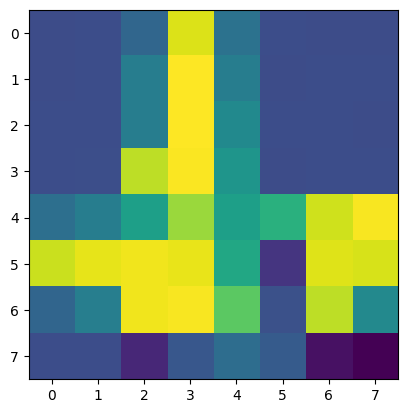

In [152]:
random = torch.randint(0,181,(1,)).item()
z =  coupling_layer(torch.from_numpy(X[y==1][random].reshape(1,64)).to(torch.float32), model, flow=2, forward=False)
z2 = coupling_layer(z, m=model2, flow=1, forward=False)
z3 = coupling_layer(z2, m=model3, flow=2, forward=False)
z4 = coupling_layer(z3, m=model4, flow=1, forward=False)
z5 = coupling_layer(z4, m=model5, flow=2, forward=False)
z6 = coupling_layer(z5, m=model6, flow=1, forward=False)
z7 = coupling_layer(z6, m=model7, flow=2, forward=False)
z8 = coupling_layer(z7, m=model8, flow=1, forward=False)
z9 = coupling_layer(z8, m=model9, flow=2, forward=False)
z10 = coupling_layer(z9, m=model10, flow=1, forward=False)
z11 = coupling_layer(z10, m=model11, flow=2, forward=False)
z12 = coupling_layer(z11, m=model12, flow=1, forward=False)
x_hat = coupling_layer(z12, m=model13, flow=2, forward=False)

plt.imshow(x_hat.detach().numpy().reshape((8,8)))

In [141]:
X[y==1][4]

array([ 0.,  0.,  0.,  1., 11.,  9.,  0.,  0.,  0.,  0.,  0.,  7., 16.,
       13.,  0.,  0.,  0.,  0.,  4., 14., 16.,  9.,  0.,  0.,  0., 10.,
       16., 11., 16.,  8.,  0.,  0.,  0.,  0.,  0.,  3., 16.,  6.,  0.,
        0.,  0.,  0.,  0.,  3., 16.,  8.,  0.,  0.,  0.,  0.,  0.,  5.,
       16., 10.,  0.,  0.,  0.,  0.,  0.,  2., 14.,  6.,  0.,  0.])

In [142]:
rotated_X1[1]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1., 13., 16., 12., 12.,
         9., 15., 14., 16., 14., 16., 16., 16., 16., 16., 16., 13.,  0.,  5.,
        14., 16., 14.,  5.,  4.,  1.,  0.,  0.,  0., 10., 12.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  3.,  0.,  0.,  0.])

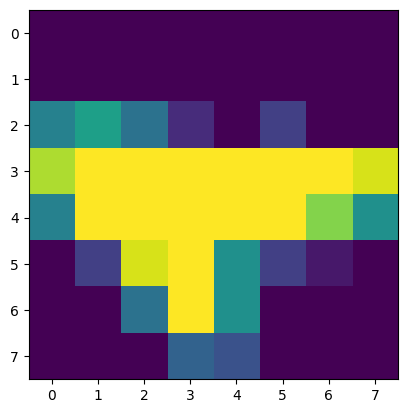

In [143]:
plt.imshow(rotated_X1[20].reshape((8,8)))